In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Wedge

## Task 1

Suppose that the trajectory of a robot can be described by a vector $p_i=\begin{bmatrix}{p_x}_i \\ {p_y}_i\end{bmatrix}$ which is a location of the robot and a sclar $\theta_i$ which is its heading (in radians).

<img src="heading.png" width="480" height="360">

While the data from a robot were read some errors occurred. Due to that, the heading values were lost and the positions of the robot are slightly off. Luckily, we've managed to recover errors in positioning, but the exact orientations are still unknown.
Some residual data suggest that heading values are distributed normally that is defined by PDF with the following mean and covariance as well as depend on errors in positioning:

$$\begin{bmatrix}s_1 \\ s_2 \\ s_3 \\ s_4 \\ s_5\end{bmatrix} \sim \mathcal{N}\Bigg(\begin{bmatrix}\mu_{s_1} \\ \mu_{s_2} \\ \mu_{s_3} \\ \mu_{s_4} \\ \mu_{s_5} \end{bmatrix}, \begin{bmatrix}\Sigma_{s_1} & 0 & 0 & 0 & 0 \\ 0 & \Sigma_{s_2} & 0 & 0 & 0 \\ 0 & 0  & \Sigma_{s_3} & 0 & 0 \\ 0 & 0 & 0  & \Sigma_{s_4} & 0  \\ 0 & 0 & 0 & 0 &\Sigma_{s_5} \end{bmatrix} \Bigg)$$

Where $s_i = \begin{bmatrix}dx_i \\ dy_i \\ \theta_i\end{bmatrix}$, $\mu_{s_i}=\begin{bmatrix}0 \\ 0 \\ {\mu_\theta}_i\end{bmatrix}$ and $\Sigma_{s_i} = \begin{bmatrix}0.3 & 0 & 0.1 \\ 0 & 0.2 & 0.2 \\ 0.1 & 0.2 & 0.5  \end{bmatrix}$

In [2]:
cov = np.array([[0.3, 0, 0.1],
                [0, 0.2, 0.2],
                [0.1, 0.2, 0.5]])

# 1.1
Knowing positions of the robot with errors (variable $robot\_positions$) and mean heading values ${\mu_\theta}_i$ for each position (variable $mu\_theta$) we want to estimate the uncertainty of our guess about heading values by $\textbf{marginalizing}$ it out of the PDF. Calculate 1-sigma of the PDF (store it in the variable $sigma\_theta\_m$ as a column vector of size $n \times 1$) and plot the 1-sigma sector using the code provided below

In [3]:
robot_positions = np.array([[2, 1],
                            [4, 3],
                            [6, -1],
                            [8, 1.5],
                            [10, -0.5]])

# Mean headings in radians
mu_theta = np.array([[np.pi / 4 - np.pi / 16],
                     [-np.pi / 4 - 2 * np.pi / 16],
                     [np.pi / 4 + 2.7 * np.pi / 16],
                     [-np.pi / 2 + 0.4 * np.pi / 16],
                     [0]])

In [4]:
sigma_theta_m = np.sqrt(np.array([[0.5],
                                  [0.5],
                                  [0.5],
                                  [0.5],
                                  [0.5]]))

In [5]:
def plot_headings(_ax, positions, _mu_theta, sigma1, color):
    _mu_theta = np.rad2deg(_mu_theta)
    sigma1 = np.rad2deg(sigma1)
    
    for pos, mu, sigma in zip(positions, _mu_theta, sigma1):
        sec_start = mu - sigma
        sec_end = mu + sigma
        
        mu_rad = np.deg2rad(mu)
        heading = np.concatenate([np.cos(mu_rad), np.sin(mu_rad)], axis=0)[None] * 0.5
        heading = np.concatenate([pos[None], pos[None] + heading], axis=0)
        
        _ax.plot(heading[:, 0], heading[:, 1], color='black', alpha=0.8)
        _ax.add_artist(Wedge(pos, 0.5, sec_start[0], sec_end[0], color=color, alpha=0.6))


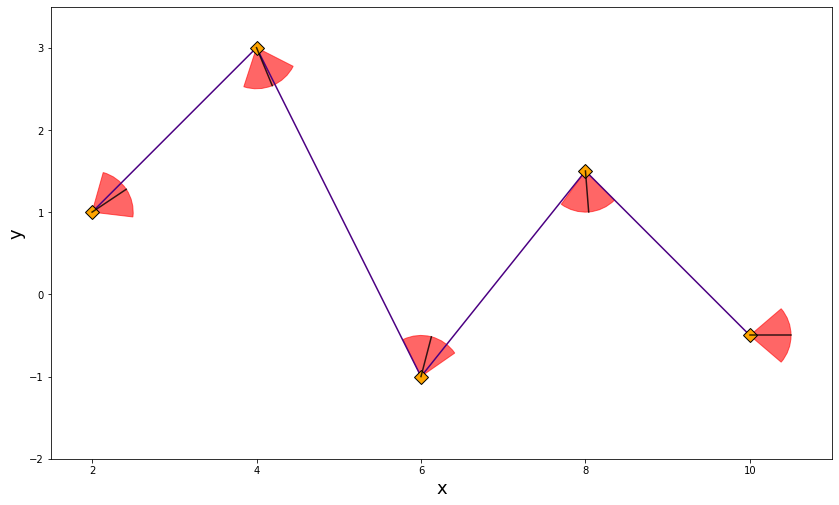

In [6]:
fig = plt.figure(figsize=(14, 9))

ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax.set_ylim(-2, 3.5)
ax.set_xlim(1.5, 11)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)


ax.plot(robot_positions[:, 0], robot_positions[:, 1], 
        color="indigo",
        marker='D', markersize=10, markerfacecolor='orange', markeredgewidth=1.0, markeredgecolor=(0, 0, 0, 1))
plot_headings(ax, robot_positions, mu_theta, sigma_theta_m, 'red')

plt.show()

# 1.2
Now, we want to correct robot's positions using recovered data (variable $positions\_err$) as well as our guess on the headigns 1-sigma estimate by utilizing the fact that we know $dx_i$ and $dy_i$. $\textbf{Condition}$ $\theta_i$ of PDF $\textbf{on}$ $dx_i$ and $dy_i$ and use their values to recalculate mean and covariance of $p(\theta_i|x_i, y_i)$. Plot the updated robot trajectory and 1-sigma sector next to the old one in is same manner as in 2.1.

In [7]:
dx = np.array([[-0.1931705 ],
               [ 0.1224564 ],
               [-0.11136686],
               [ 0.28472354],
               [-0.29425286]])

dy = np.array([[ 0.16510238],
               [-0.00937599],
               [-0.3699997 ],
               [ 0.3970382 ],
               [ 0.08117404]])


In [8]:
def condition(_mu, _cov, _dx, _dy):
    """
    _mu: a list with N items where i-th item is an n x 1 vector
    _cov: 3 x 3 covariance matrix which is the same for all positions
    """
    _new_mu = []
    _sigma_theta_c = []
    
    for mu_i, dx_i, dy_i in zip(_mu, _dx, _dy):
        x_b = np.array([dx_i, dy_i])
        cov_ab = cov[None, :2, 2]
        cov_b = cov[:2, :2]
        cov_a = cov[[2], [2]]
        new_mu_i = mu_i + cov_ab @ np.linalg.inv(cov_b) @ x_b 
        new_cov_i = cov_a - cov_ab @ np.linalg.inv(cov_b) @ np.transpose(cov_ab)
        
        _new_mu.append(new_mu_i[0])
        _sigma_theta_c.append(new_cov_i[0])
    
    return np.array(_new_mu), np.array(_sigma_theta_c)
    
    

In [9]:
new_robot_positions = robot_positions + np.concatenate([dx, dy], axis=-1)
new_mu_theta, sigma_theta_c = condition(mu_theta, cov, dx, dy)


sigma_theta_c = np.sqrt(sigma_theta_c)

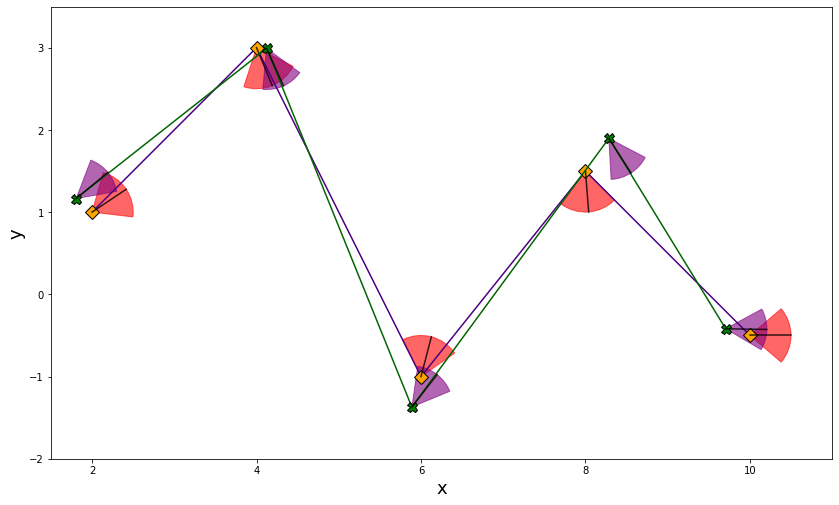

In [10]:
fig2 = plt.figure(figsize=(14, 9))

ax2 = fig2.add_subplot(1, 1, 1, aspect='equal')

ax2.set_ylim(-2, 3.5)
ax2.set_xlim(1.5, 11)
ax2.set_xlabel('x', fontsize=18)
ax2.set_ylabel('y', fontsize=18)


ax2.plot(robot_positions[:, 0], robot_positions[:, 1], 
         color="indigo",
         marker='D', markersize=10, markerfacecolor='orange', markeredgewidth=1.0, markeredgecolor=(0, 0, 0, 1))
plot_headings(ax2, robot_positions, mu_theta, sigma_theta_m, 'red')
        
ax2.plot(new_robot_positions[:, 0], new_robot_positions[:, 1], 
         color="darkgreen",
         marker='X', markersize=10, markerfacecolor='green', markeredgewidth=1.0, markeredgecolor=(0, 0, 0, 1))
plot_headings(ax2, new_robot_positions, new_mu_theta, sigma_theta_c, 'purple')

plt.show()

<b>Question:</b> If cross-correlation terms are zero then will the conditioning have any effect on the variable for which conditioning is performed?

## Task 2
Prove block martix inversion formula:

$$\begin{bmatrix}A & B \\ C & D\end{bmatrix}^{-1} = \begin{bmatrix}A^{-1} + A^{-1}B(D - CA^{-1}B)^{-1}CA^{-1} & -A^{-1}B(D - CA^{-1}B)^{-1} \\ -(D - CA^{-1}B)^{-1}CA^{-1} & (D - CA^{-1}B)^{-1}\end{bmatrix}$$

Make use of the following equalities:

* If $A=\begin{bmatrix}A_{11} & A_{12} \\ 0 & A_{22} \end{bmatrix}$, then $A^{-1}=\begin{bmatrix}A_{11}^{-1} & -A_{11}^{-1}A_{12}A_{22}^{-1} \\ 0 & A_{22}^{-1} \end{bmatrix}$. The same holds for lower triangular matrix.

* $(AB)^{-1}=B^{-1}A^{-1}$
* $M/D = A - BD^{-1}C$ (Schur complement), where $M=\begin{bmatrix}A & B \\ C & D\end{bmatrix}$

**Hint:** factorize the matrix into two triangular matrices. Try to form Schur complement on one of the diagonal elements.


### Solution:

Let pick the following factorization: $\begin{bmatrix}A & B \\ C & D\end{bmatrix}=\begin{bmatrix}K & 0 \\ M & N\end{bmatrix}\begin{bmatrix}W & X \\ 0 & Z\end{bmatrix}$, where $K$, $M$, $N$, $W$, $X$ and $Z$ are to be defined. We've got the system of equations where the number of unknown variables is larger than the number of equations, hence we make an assumption that $K=I$ and $N=I$:

$$KW=A$$
$$KX=B$$
$$MW=C$$
$$MX + NZ=D$$

Solving the system we get $\begin{bmatrix}A & B \\ C & D\end{bmatrix}=\begin{bmatrix}I & 0 \\ CA^{-1} & I\end{bmatrix}\begin{bmatrix}A & B \\ 0 & D - CA^{-1}B\end{bmatrix}$

The inversion of the factorization gives:

$$\begin{bmatrix}A & B \\ C & D\end{bmatrix}^{-1}=\begin{bmatrix}A & B \\ 0 & D - CA^{-1}B\end{bmatrix}^{-1}\begin{bmatrix}I & 0 \\ CA^{-1} & I\end{bmatrix}^{-1}=\begin{bmatrix}A^{-1} & -A^{-1}B(D - CA^{-1}B)^{-1} \\ 0 & (D - CA^{-1}B)^{-1}\end{bmatrix}\begin{bmatrix}I & 0 \\ -CA^{-1} & I\end{bmatrix}$$

Calculating the product we get the required answer:

$$\begin{bmatrix}A & B \\ C & D\end{bmatrix}^{-1}=\begin{bmatrix}A^{-1} & -A^{-1}B(D - CA^{-1}B)^{-1} \\ 0 & (D - CA^{-1}B)^{-1}\end{bmatrix}\begin{bmatrix}I & 0 \\ -CA^{-1} & I\end{bmatrix}=\begin{bmatrix}A^{-1} + A^{-1}B(D - CA^{-1}B)^{-1}CA^{-1} & -A^{-1}B(D - CA^{-1}B)^{-1} \\ -(D - CA^{-1}B)^{-1}CA^{-1} & (D - CA^{-1}B)^{-1}\end{bmatrix}$$

